In [1]:
import warnings
warnings.filterwarnings("ignore") #for perfect seperation

In [2]:
import pandas as pd
#df = pd.read_csv('/kaggle/input/banana/banana_quality.csv')
df = pd.read_csv('banana_quality.csv')

In [3]:
df

Size    Weight  Sweetness  Softness  HarvestTime  Ripeness  \
0    -1.924968  0.468078   3.077832 -1.472177     0.294799  2.435570   
1    -2.409751  0.486870   0.346921 -2.495099    -0.892213  2.067549   
2    -0.357607  1.483176   1.568452 -2.645145    -0.647267  3.090643   
3    -0.868524  1.566201   1.889605 -1.273761    -1.006278  1.873001   
4     0.651825  1.319199  -0.022459 -1.209709    -1.430692  1.078345   
...        ...       ...        ...       ...          ...       ...   
7995 -6.414403  0.723565   1.134953  2.952763     0.297928 -0.156946   
7996  0.851143 -2.217875  -2.812175  0.489249    -1.323410 -2.316883   
7997  1.422722 -1.907665  -2.532364  0.964976    -0.562375 -1.834765   
7998 -2.131904 -2.742600  -1.008029  2.126946    -0.802632 -3.580266   
7999 -2.660879 -2.044666   0.159026  1.499706    -1.581856 -1.605859   

       Acidity Quality  
0     0.271290    Good  
1     0.307325    Good  
2     1.427322    Good  
3     0.477862    Good  
4     2.812442    Good  
...        ...     ...  
7995  2.398091     Bad  
7996  2.113136     Bad  
7997  0.697361     Bad  
7998  0.423569     Bad  
7999  1.435644     Bad  

[8000 rows x 8 columns]

In [4]:
X = df.drop('Quality', axis=1)
y = df['Quality']
y = y.map({"Good": 1, "Bad": 0})

In [5]:
from tqdm import tqdm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
import numpy as np
import pandas as pd

np.random.seed(21)

replications = 10000

intercept_p_values = []
x1_data_p_values = []

# Generate the AR(1) time series

# Calculate the p-values for each run
for i in tqdm(range(replications)):
    X_prime = X.sample(n=20)
    #X.sample(n=17, random_state = 21) #always the same sample
    y_prime = y.loc[X_prime.index]
    try:
        sm_model = Logit(y_prime, add_constant(X_prime)).fit(disp=0) #like 30min
        intercept_p_values.append(sm_model.pvalues[0])
        x1_data_p_values.append(sm_model.pvalues[1])
    except Exception:
        None

df = pd.DataFrame({"intercept p-values": intercept_p_values, "x1 p-values": x1_data_p_values})

df.to_csv("p_values_banana.csv", index=False)

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/conda/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarn

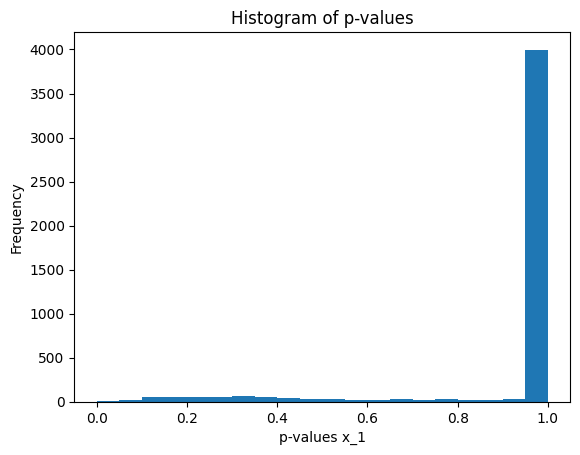

In [6]:
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt

# Show a histogram of the p-values
plt.hist(x1_data_p_values, bins=20) #paper has 20 bins
plt.xlabel('p-values x_1')
plt.ylabel('Frequency')
plt.title('Histogram of p-values')
#plt.ylim((0, 2000))
plt.show()

In [7]:
import random
import numpy as np
from sklearn.feature_selection import mutual_info_classif

def test_statistic(X, y):
    matrix_multiplication = X[:, 0] @ y #np.transpose(X) @ y
    #matrix_multiplication = np.matmul(np.transpose(X), y)
    return matrix_multiplication

#def test_statistic(X, y):
#    mi_scores = mutual_info_classif(X, y)
#    return mi_scores

def adjusted_p_value(X, y, test_statistic, j, K):
    X = np.array(X)
    org_X = X.copy()
    summation = []
    for k in range(K):
        for n in range(X.shape[0]):
            possible_samples = np.append(X[n][:j], X[n][j+1:])
            #print(possible_samples.size) == 199
            sample = random.choice(possible_samples)
            X[n][j] = sample

        #print(test_statistic(X, y) > test_statistic(org_X, y))
        summation.append(1 if np.sum(test_statistic(X, y)) > np.sum(test_statistic(org_X, y)) else 0)
        #summation.append(1 if test_statistic(X[:, 0].reshape(-1, 1), y)[0] > test_statistic(org_X[:, 0].reshape(-1, 1), y)[0] else 0)
    adjusted_p_value = 1/(K+1) * (1 + np.sum(summation))

    return adjusted_p_value

In [8]:
K = 300

p_values = []

# Calculate the p-values for each run
for i in tqdm(range(replications)):
    X_prime = X.sample(n=20)
    #X.sample(n=17, random_state = 21) #always the same sample
    y_prime = y.loc[X_prime.index]

    p_values_adjusted = adjusted_p_value(X_prime, y_prime, test_statistic, 0, K)
    p_values.append(p_values_adjusted)

df = pd.DataFrame({"adjusted p-values": p_values})

df.to_csv("p_values_adj.csv", index=False)

100%|██████████| 10000/10000 [12:59<00:00, 12.84it/s]


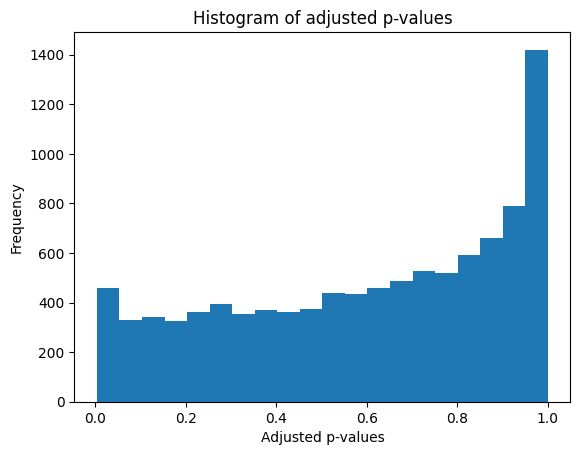

In [9]:
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt

# Show a histogram of the p-values
plt.hist(p_values, bins=20) #paper has 20 bins
plt.xlabel('Adjusted p-values')
plt.ylabel('Frequency')
plt.title('Histogram of adjusted p-values')
#plt.ylim((0, 2000))
plt.show()